## Imports

In [147]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#INLINE STATEMENT for matplot
#AUTOLOAD --NOT ESSENTIAL

#Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import classification_report, precision_recall_fscore_support


from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV


from scipy.stats import uniform
from sklearn.decomposition import PCA

from sklearn import set_config; set_config(display='text')

from sktime.classification.interval_based import TimeSeriesForestClassifier #pip install sktime




# Data frame

In [2]:
circor_raw_df = pd.read_csv('../circor/training_data.csv') #This is the recently edited dataframe from Google cloud
circor_raw_df

,Patient ID,Recording locations:,Age,Sex,Height,Weight,Pregnancy status,Murmur,Murmur locations,Most audible location,...,Systolic murmur pitch,Systolic murmur quality,Diastolic murmur timing,Diastolic murmur shape,Diastolic murmur grading,Diastolic murmur pitch,Diastolic murmur quality,Outcome,Campaign,Additional ID
0,2530,AV+PV+TV+MV,Child,Female,98.0,15.9,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
1,9979,AV+PV+TV+MV,Child,Female,103.0,13.1,False,Present,AV+MV+PV+TV,TV,...,High,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
2,9983,AV+PV+TV+MV,Child,Male,115.0,19.1,False,Unknown,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
3,13918,AV+PV+TV+MV,Child,Male,98.0,15.9,False,Present,TV,TV,...,Low,Blowing,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
4,14241,AV+PV+TV+MV,Child,Male,87.0,11.2,False,Present,AV+MV+PV+TV,PV,...,Low,Harsh,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,85340,AV+PV+TV+MV,Child,Male,105.0,16.6,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,CC2015,NaN
938,85341,AV+PV+TV+MV,Child,Male,92.0,15.2,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,CC2015,NaN
939,85343,AV+PV+TV+MV,Child,Female,97.0,13.5,False,Present,MV+TV,TV,...,Low,Blowing,NaN,NaN,NaN,NaN,NaN,Abnormal,CC2015,NaN
940,85345,AV+PV,Child,Female,132.0,38.1,False,Absent,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,CC2015,NaN


## Selection by age-groups [Non-adoloscents or only children]

In [3]:
circor_raw_df.loc[:,'Age'].value_counts()

Child         664
Infant        126
Adolescent     72
Neonate         6
Name: Age, dtype: int64

In [4]:
circor_raw_df.columns

Index(['Patient ID', 'Recording locations:', 'Age', 'Sex', 'Height', 'Weight',
       'Pregnancy status', 'Murmur', 'Murmur locations',
       'Most audible location', 'Systolic murmur timing',
       'Systolic murmur shape', 'Systolic murmur grading',
       'Systolic murmur pitch', 'Systolic murmur quality',
       'Diastolic murmur timing', 'Diastolic murmur shape',
       'Diastolic murmur grading', 'Diastolic murmur pitch',
       'Diastolic murmur quality', 'Outcome', 'Campaign', 'Additional ID'],
      dtype='object')

In [5]:
non_adolescent_patients = circor_raw_df[~(circor_raw_df['Age']=='Adolescent')].loc[:, ['Patient ID']]
non_adolescent_patients

,Patient ID
0,2530
1,9979
2,9983
3,13918
4,14241
...,...
937,85340
938,85341
939,85343
940,85345


In [6]:
non_adolescent_patients = non_adolescent_patients.reset_index(drop=True)
non_adolescent_patients

,Patient ID
0,2530
1,9979
2,9983
3,13918
4,14241
...,...
865,85340
866,85341
867,85343
868,85345


In [7]:
adolescent_patients = circor_raw_df[(circor_raw_df['Age']=='Adolescent')].loc[:, ['Patient ID']]
adolescent_patients

,Patient ID
12,36327
19,40840
21,44514
22,45843
26,46778
...,...
860,85207
866,85217
876,85236
889,85253


In [8]:
_.shape

(72, 1)

**In the following we shall study only child patients for better grouping the heartbeat rates**

In [9]:
child_patients = circor_raw_df[(circor_raw_df['Age']=='Child')].loc[:, ['Patient ID']]
child_patients = child_patients.reset_index(drop=True)
child_patients

,Patient ID
0,2530
1,9979
2,9983
3,13918
4,14241
...,...
659,85337
660,85340
661,85341
662,85343


## Selected dataframe with numpy arrays

In [10]:
circor_df = pd.read_csv('../circor/processed_data/df_new.csv')
circor_df

,patient_id,select,audible,outcome
0,2530,TV,TV,Abnormal
1,9979,TV,TV,Abnormal
2,13918,PV,TV,Abnormal
3,14241,AV,PV,Abnormal
4,14998,AV,AV,Abnormal
...,...,...,...,...
514,85337,PV,PV,Normal
515,85338,AV,AV,Normal
516,85340,PV,PV,Normal
517,85341,MV,MV,Normal


In [11]:
circor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  519 non-null    int64 
 1   select      519 non-null    object
 2   audible     519 non-null    object
 3   outcome     519 non-null    object
dtypes: int64(1), object(3)
memory usage: 16.3+ KB


In [12]:
# circor_df_1 = circor_df[~circor_df['patient_id'].isin(list(adolescent_patients.loc[:, 'Patient ID']))]
# circor_df_2 = circor_df_1.reset_index(drop=True)
# circor_df_2

In [13]:
circor_df_1 = circor_df[circor_df['patient_id'].isin(list(child_patients.loc[:, 'Patient ID']))]
circor_df_2 = circor_df_1.reset_index(drop=True)
circor_df_2

,patient_id,select,audible,outcome
0,2530,TV,TV,Abnormal
1,9979,TV,TV,Abnormal
2,13918,PV,TV,Abnormal
3,14241,AV,PV,Abnormal
4,14998,AV,AV,Abnormal
...,...,...,...,...
423,85334,TV,TV,Normal
424,85337,PV,PV,Normal
425,85340,PV,PV,Normal
426,85341,MV,MV,Normal


In [119]:
# circor_df = circor_df.loc[0:-1]
# circor_df

In [14]:
circor_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  428 non-null    int64 
 1   select      428 non-null    object
 2   audible     428 non-null    object
 3   outcome     428 non-null    object
dtypes: int64(1), object(3)
memory usage: 13.5+ KB


In [139]:
# npy_list_no_adol = [np.load(f'../circor/processed_data/npy_files/{circor_df_2.iloc[ind]["patient_id"]}_{circor_df_2.iloc[ind]["audible"]}.npy')[:2400] \
#             for ind in circor_df_2.index]

In [122]:
# for row in circor_df.iterrows():
#     print(row)

In [15]:
circor_df_2["npy_arrays"] = circor_df_2.apply(lambda row:
                          np.load(f'../circor/processed_data/npy_files/{int(row[0])}_{row[2]}.npy')[:2400], axis=1)
circor_df_2

,patient_id,select,audible,outcome,npy_arrays
0,2530,TV,TV,Abnormal,"[-0.014939931, -0.015137674, -0.015344764, -0...."
1,9979,TV,TV,Abnormal,"[0.009304384, 0.021842243, 0.03387945, 0.04530..."
2,13918,PV,TV,Abnormal,"[-0.0057269894, -0.0052762283, -0.0048356913, ..."
3,14241,AV,PV,Abnormal,"[-0.02624997, -0.02599725, -0.025725888, -0.02..."
4,14998,AV,AV,Abnormal,"[-0.006009835, -0.005675483, -0.005332388, -0...."
...,...,...,...,...,...
423,85334,TV,TV,Normal,"[-0.033141844, -0.029803721, -0.02654953, -0.0..."
424,85337,PV,PV,Normal,"[0.000518905, -0.0009550942, -0.0023938122, -0..."
425,85340,PV,PV,Normal,"[-0.031074673, -0.029285496, -0.027446643, -0...."
426,85341,MV,MV,Normal,"[0.0035850152, 0.003623246, 0.003651578, 0.003..."


In [16]:
circor_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  428 non-null    int64 
 1   select      428 non-null    object
 2   audible     428 non-null    object
 3   outcome     428 non-null    object
 4   npy_arrays  428 non-null    object
dtypes: int64(1), object(4)
memory usage: 16.8+ KB


In [17]:
circor_df_3 = circor_df_2.loc[:, ['patient_id', 'npy_arrays', 'outcome']]
circor_df_3.loc[:, 'outcome'] = circor_df_3.loc[:, 'outcome'].map({'Abnormal': 1, 'Normal': 0})
circor_df_3

/tmp/ipykernel_33801/46951013.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  circor_df_3.loc[:, 'outcome'] = circor_df_3.loc[:, 'outcome'].map({'Abnormal': 1, 'Normal': 0})


,patient_id,npy_arrays,outcome
0,2530,"[-0.014939931, -0.015137674, -0.015344764, -0....",1
1,9979,"[0.009304384, 0.021842243, 0.03387945, 0.04530...",1
2,13918,"[-0.0057269894, -0.0052762283, -0.0048356913, ...",1
3,14241,"[-0.02624997, -0.02599725, -0.025725888, -0.02...",1
4,14998,"[-0.006009835, -0.005675483, -0.005332388, -0....",1
...,...,...,...
423,85334,"[-0.033141844, -0.029803721, -0.02654953, -0.0...",0
424,85337,"[0.000518905, -0.0009550942, -0.0023938122, -0...",0
425,85340,"[-0.031074673, -0.029285496, -0.027446643, -0....",0
426,85341,"[0.0035850152, 0.003623246, 0.003651578, 0.003...",0


## Train test split

In [18]:
X = circor_df_3.loc[:, 'npy_arrays']
y = circor_df_3.loc[:, 'outcome']

In [19]:
#Convert to a data frame form with numpy elements as features
X = X.apply(lambda row: pd.Series(row))
X = X.reset_index(drop=True)
X

,0,1,2,3,4,5,6,7,8,9,...,2390,2391,2392,2393,2394,2395,2396,2397,2398,2399
0,-0.014940,-0.015138,-0.015345,-0.015561,-0.015785,-0.016017,-0.016255,-0.016500,-0.016750,-0.017004,...,-0.021837,-0.020712,-0.019479,-0.018152,-0.016744,-0.015268,-0.013739,-0.012170,-0.010578,-0.008977
1,0.009304,0.021842,0.033879,0.045306,0.056014,0.065896,0.074863,0.082851,0.089815,0.095731,...,0.050114,0.058153,0.063773,0.067161,0.068616,0.068502,0.067116,0.064680,0.061295,0.056942
2,-0.005727,-0.005276,-0.004836,-0.004408,-0.003996,-0.003603,-0.003231,-0.002883,-0.002563,-0.002271,...,0.006510,0.007567,0.008368,0.008822,0.008842,0.008344,0.007253,0.005504,0.003052,-0.000126
3,-0.026250,-0.025997,-0.025726,-0.025434,-0.025120,-0.024778,-0.024405,-0.024001,-0.023565,-0.023100,...,-0.012253,-0.012578,-0.012836,-0.012995,-0.013030,-0.012911,-0.012613,-0.012114,-0.011398,-0.010458
4,-0.006010,-0.005675,-0.005332,-0.004981,-0.004624,-0.004261,-0.003895,-0.003527,-0.003161,-0.002797,...,0.059234,0.045491,0.014588,-0.020497,-0.046473,-0.056446,-0.048871,-0.030119,-0.013631,-0.010627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,-0.033142,-0.029804,-0.026550,-0.023404,-0.020389,-0.017527,-0.014838,-0.012335,-0.010028,-0.007927,...,-0.086332,-0.093527,-0.101049,-0.108533,-0.115540,-0.121655,-0.126665,-0.130605,-0.133600,-0.135789
424,0.000519,-0.000955,-0.002394,-0.003777,-0.005084,-0.006292,-0.007378,-0.008325,-0.009114,-0.009734,...,0.007789,0.006701,0.005612,0.004599,0.003741,0.003107,0.002742,0.002664,0.002864,0.003301
425,-0.031075,-0.029285,-0.027447,-0.025559,-0.023625,-0.021648,-0.019631,-0.017578,-0.015496,-0.013390,...,0.114691,0.119021,0.122603,0.125608,0.128198,0.130509,0.132572,0.134369,0.135841,0.136879
426,0.003585,0.003623,0.003652,0.003670,0.003677,0.003674,0.003660,0.003635,0.003598,0.003551,...,-0.001713,-0.001729,-0.001745,-0.001760,-0.001776,-0.001792,-0.001808,-0.001824,-0.001839,-0.001855


In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=64)
X_train

,0,1,2,3,4,5,6,7,8,9,...,2390,2391,2392,2393,2394,2395,2396,2397,2398,2399
12,-0.000915,-0.001033,-0.001149,-0.001262,-0.001371,-0.001476,-0.001576,-0.001671,-0.001760,-0.001844,...,0.002240,0.002358,0.002470,0.002573,0.002669,0.002757,0.002836,0.002906,0.002967,0.003019
141,0.005205,0.004495,0.003791,0.003095,0.002409,0.001733,0.001070,0.000422,-0.000212,-0.000828,...,-0.002446,-0.004477,-0.006515,-0.008533,-0.010503,-0.012395,-0.014185,-0.015846,-0.017357,-0.018695
252,-0.004828,-0.004697,-0.004552,-0.004390,-0.004207,-0.003998,-0.003761,-0.003492,-0.003191,-0.002857,...,-0.001413,-0.001537,-0.001656,-0.001768,-0.001874,-0.001973,-0.002067,-0.002163,-0.002270,-0.002392
310,0.026386,0.024894,0.023608,0.022530,0.021653,0.020969,0.020464,0.020114,0.019893,0.019767,...,0.004233,0.004203,0.004174,0.004145,0.004117,0.004089,0.004063,0.004038,0.004013,0.003989
292,0.009027,0.008695,0.008350,0.007995,0.007631,0.007260,0.006887,0.006512,0.006141,0.005776,...,-0.000028,-0.000030,-0.000033,-0.000036,-0.000039,-0.000042,-0.000045,-0.000048,-0.000051,-0.000055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.049976,0.048704,0.047025,0.044652,0.041381,0.037138,0.032030,0.026360,0.020575,0.015157,...,0.042250,0.043622,0.044248,0.044260,0.043818,0.043073,0.042094,0.040922,0.039525,0.037805
307,-0.002656,-0.002299,-0.001954,-0.001620,-0.001297,-0.000984,-0.000677,-0.000373,-0.000065,0.000255,...,-0.001915,-0.001996,-0.002088,-0.002189,-0.002301,-0.002423,-0.002556,-0.002697,-0.002846,-0.003000
54,0.002958,0.002966,0.003238,0.003810,0.004666,0.005733,0.006887,0.007959,0.008756,0.009088,...,0.090341,0.082216,0.073355,0.063948,0.054197,0.044311,0.034477,0.024845,0.015546,0.006694
166,-0.005105,-0.004992,-0.004880,-0.004770,-0.004661,-0.004554,-0.004449,-0.004346,-0.004243,-0.004143,...,0.003770,0.003772,0.003772,0.003772,0.003771,0.003769,0.003765,0.003761,0.003756,0.003749


In [21]:
mscaler = MinMaxScaler()
X_train = mscaler.fit_transform(X_train)
X_test = mscaler.transform(X_test)

In [22]:
# plt.plot(np.max(npy_list_no_adol, axis=1))

In [364]:
# unique, counts = np.unique(npy_list_no_adol, axis =1, return_counts=True)
# counts.shape
# #print(np.asarray((unique, counts)).T)


(400,)

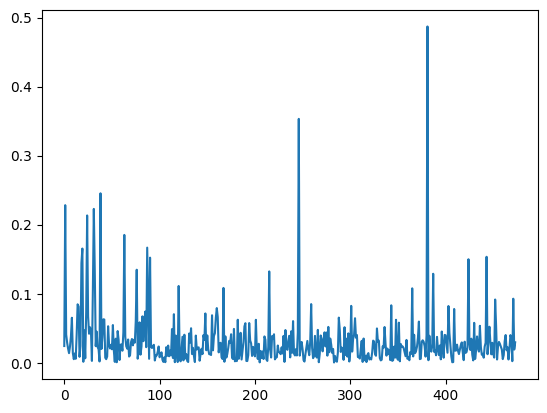

In [355]:
# plt.plot(np.std(npy_list_no_adol, axis=1))

In [14]:
# npy_df_no_adol.outcome.value_counts()

0    252
1    222
Name: outcome, dtype: int64

# KNN analysis

In [188]:
# np.ravel(X)

In [213]:
# np.ravel(X).map(lambda x: x.flatten())

In [183]:
# np.ravel(X).flatten().shape

(474,)

In [189]:
# np.reshape(np.ravel(X), (474, 2400), order='A')

## Cross validation

In [27]:
knn_cv_results = cross_validate(KNeighborsClassifier(n_neighbors=7, weights='uniform',
                                algorithm='auto',
                                leaf_size=30,
                                p=2,
                                metric='minkowski',
                                metric_params=None,
                                n_jobs=None), 
                                X, y, 
                                cv=10, 
                                scoring=['recall']) 

knn_score = knn_cv_results['test_recall'].mean()
knn_score

0.34157894736842104

**We find that for children with 10 fold cross-val:**
- With the first 2400 points, we have a recall rate of about $0.378$ for $\textrm{n_neighbours} = 5$ and about $0.343$ for $\textrm{n_neighbours} = 7$ 

OLDER [some ERRORS and for non-adoloscents]
    
- With the first 6000 points, we have a recall rate of about $0.342$ for $\textrm{n_neighbours} = 5$ and about $0.338$ for $\textrm{n_neighbours} = 7$ 
- With the first 2000 points, we have a recall rate of about $0.419$ for $\textrm{n_neighbours} = 5$ and about $0.414$ for $\textrm{n_neighbours} = 7$ 
- With 1200 points chosen evenly from the first 6000 points, $0.334$ for $\textrm{n_neighbours} = 5$ and about $0.306$ for $\textrm{n_neighbours} = 7$
- With 400 points chosen evenly from the first 2000 points, $0.427$ for $\textrm{n_neighbours} = 5$ and about $0.414$ for $\textrm{n_neighbours} = 7$ 

**While keeping all the patients, we have: TO DO**

## Holdout method

Without cross validation, and a simple holdout method, we find:

In [113]:
knn = KNeighborsClassifier(n_neighbors=5)

In [114]:
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0])

In [115]:
print(classification_report(y_test_array, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.51      0.55        74
           1       0.44      0.51      0.47        55

    accuracy                           0.51       129
   macro avg       0.51      0.51      0.51       129
weighted avg       0.52      0.51      0.51       129



In [116]:
print(precision_recall_fscore_support(y_test, y_pred, average='macro'))

(0.5110576923076924, 0.5113022113022112, 0.5086754126110876, None)


In [461]:
# recall_unscaled = precision_recall_fscore_support(y_test, y_pred, average='macro')[1]
# recall_unscaled

0.4954545454545455

# With PCA

In [51]:
pca = PCA(n_components=120).fit(X_train)

In [52]:
pca.components_.shape

(120, 2400)

In [43]:
pca.explained_variance_;

In [53]:
X_transformed = pca.transform(X)

In [54]:
X_transformed.shape

(428, 120)

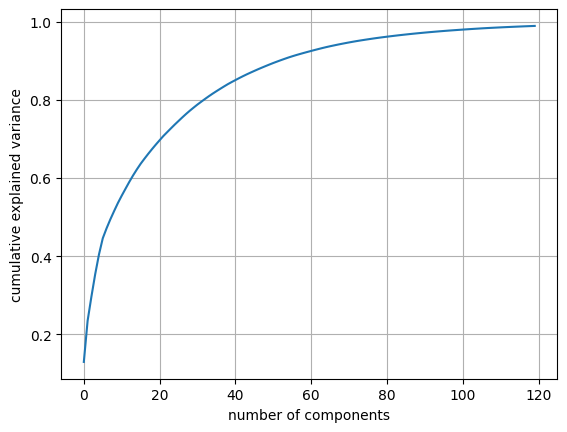

In [55]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid()

In [63]:
knn_cv_results_pca = cross_validate(KNeighborsClassifier(n_neighbors=7, weights='uniform',
                                algorithm='auto',
                                leaf_size=30,
                                p=2,
                                metric='minkowski',
                                metric_params=None,
                                n_jobs=None), 
                                X_transformed, y, 
                                cv=10, 
                                scoring=['recall']) 

knn_score_pca = knn_cv_results_pca['test_recall'].mean()
knn_score_pca

0.32736842105263164

**We find that for non-adoloscents with 10 fold cross-val and a PCA step:**

ERROR (may be) commented out in the cell:

%%- With $\textrm{n_components}=400$, and the first 6000 points, we have a recall rate of about $0.343$ for $\textrm{n_neighbours} = 5$ and about %%$0.324$
%%  for $\textrm{n_neighbours} = 7$ 
%%- With $\textrm{n_components}=400$, and the first 2000 points, we have a recall rate of about $0.419$ for $\textrm{n_neighbours} = 5$ and about $0.414$
%%  for $\textrm{n_neighbours} = 7$  
%%- With $\textrm{n_components}=400$, and 1200 points chosen evenly from the first 6000 points, $0.4186$ for $\textrm{n_neighbours} = 5$ and about %%$0.414$ for $\textrm{n_neighbours} = 7$
%%- With $\textrm{n_components}=250$, and 1200 points chosen evenly from the first 6000 points, $0.333$ for $\textrm{n_neighbours} = 5$ and about %%$0.297$ for $\textrm{n_neighbours} = 7$
%%- With $\textrm{n_components}=100$, and 400 points chosen evenly from the first 2000 points, $0.437$ for $\textrm{n_neighbours} = 5$ and about %%$0.405$ for $\textrm{n_neighbours} = 7$
%%- With $\textrm{n_components}=50$, and 1200 points chosen evenly from the first 2000 points, $0.409$ for $\textrm{n_neighbours} = 5$ and about %%$0.373$ for $\textrm{n_neighbours} = 7$

**We find that for children with 10 fold cross-val for X_train and a PCA step:**

- With $\textrm{n_components}=120$, and the first 2400 points, $0.363$ for $\textrm{n_neighbours} = 5$ and about $0.327$ for $\textrm{n_neighbours} = 7$

# SVC

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=64)

In [136]:
type(y)

pandas.core.series.Series

In [137]:
svc = SVC(C=0.1,
    kernel='rbf',
    degree=5,
    gamma='scale',
    coef0=0.0,
    shrinking=True,
    probability=False,
    tol=0.001,
    cache_size=200,
    class_weight=None,
    verbose=False,
    max_iter=-1,
    decision_function_shape='ovr',
    break_ties=False,
    random_state=32)

In [138]:
clf_svc = make_pipeline(MinMaxScaler(), svc)
clf_svc.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('svc', SVC(C=0.1, degree=5, random_state=32))])

In [139]:
y_pred = clf_svc.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

**ERROR, ALL THE VALUES ARE ZERO**

In [140]:
y_test

47     0
350    0
328    1
327    1
383    1
      ..
87     1
178    1
239    1
50     0
186    0
Name: outcome, Length: 129, dtype: int64

In [141]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.57      0.73       129
           1       0.00      0.00      0.00         0

    accuracy                           0.57       129
   macro avg       0.50      0.29      0.36       129
weighted avg       1.00      0.57      0.73       129



/home/fermion/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fermion/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/fermion/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [126]:
svc_cv_results = cross_validate(clf_svc,
                                X, y, 
                                cv=10, 
                                scoring=['recall']) 

svc_score = knn_cv_results['test_recall'].mean()
svc_score

0.34157894736842104

**TO FIX**

# Grid Search

## SVC pipeline

In [143]:
svc = SVC()
clf_svc = make_pipeline(MinMaxScaler(), svc)

In [144]:
clf_svc.get_params()

{'memory': None,
 'steps': [('minmaxscaler', MinMaxScaler()), ('svc', SVC())],
 'verbose': False,
 'minmaxscaler': MinMaxScaler(),
 'svc': SVC(),
 'minmaxscaler__clip': False,
 'minmaxscaler__copy': True,
 'minmaxscaler__feature_range': (0, 1),
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [145]:
%%time
# Random search for pipe with MinMaxScaler and SVC classifier
search_svc = RandomizedSearchCV(
    clf_svc, 
    param_distributions ={
        'svc__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'svc__gamma': ['scale', 'auto'],
        'svc__C': uniform(0.1,10),
        'svc__degree' : [3, 5, 8]
    },
    cv=5,
    n_iter = 50,
    scoring="recall"
)

search_svc.fit(X,y)

clf_svc_tuned = search_svc.best_estimator_
clf_svc_tuned

CPU times: user 1min 12s, sys: 1.32 s, total: 1min 14s
Wall time: 1min 14s


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('svc', SVC(C=6.75713264940173, degree=5, kernel='poly'))])

In [148]:
clf_svc_tuned.get_params()

{'memory': None,
 'steps': [('minmaxscaler', MinMaxScaler()),
  ('svc', SVC(C=6.75713264940173, degree=5, kernel='poly'))],
 'verbose': False,
 'minmaxscaler': MinMaxScaler(),
 'svc': SVC(C=6.75713264940173, degree=5, kernel='poly'),
 'minmaxscaler__clip': False,
 'minmaxscaler__copy': True,
 'minmaxscaler__feature_range': (0, 1),
 'svc__C': 6.75713264940173,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 5,
 'svc__gamma': 'scale',
 'svc__kernel': 'poly',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [150]:
scores = cross_val_score(clf_svc_tuned, X,y,cv=10, scoring="recall")
score = scores.mean()

print(scores)
print(scores.mean())

[0.65       0.5        0.4        0.36842105 0.42105263 0.73684211
 0.47368421 0.42105263 0.47368421 0.57894737]
0.5023684210526316


## KNN pipeline

In [151]:
knn = KNeighborsClassifier()
clf_knn = make_pipeline(MinMaxScaler(), knn)
clf_knn

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [152]:
clf_knn.get_params()

{'memory': None,
 'steps': [('minmaxscaler', MinMaxScaler()),
  ('kneighborsclassifier', KNeighborsClassifier())],
 'verbose': False,
 'minmaxscaler': MinMaxScaler(),
 'kneighborsclassifier': KNeighborsClassifier(),
 'minmaxscaler__clip': False,
 'minmaxscaler__copy': True,
 'minmaxscaler__feature_range': (0, 1),
 'kneighborsclassifier__algorithm': 'auto',
 'kneighborsclassifier__leaf_size': 30,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 5,
 'kneighborsclassifier__p': 2,
 'kneighborsclassifier__weights': 'uniform'}

In [153]:
%%time

# Random search for pipe with MinMaxScaler and KNN classifier
search_knn = RandomizedSearchCV(
    clf_knn, 
    param_distributions ={
        'kneighborsclassifier__n_neighbors' : [1,2,3,4,5,6,7,8,9,10,11,12],
        'kneighborsclassifier__metric': ['minkowski', 'auto'],
        'kneighborsclassifier__algorithm' :['auto', 'ball_tree', 'kd_tree', 'brute'],
        'kneighborsclassifier__weights' : ['uniform', 'distance'],
        'kneighborsclassifier__leaf_size':[20,30,40],
        'kneighborsclassifier__p':[1,2,3]
    },
    cv=5,
    n_iter = 50,
    scoring="recall"
)

search_knn.fit(X,y)

clf_knn_tuned = search_knn.best_estimator_
clf_knn_tuned

CPU times: user 1min 46s, sys: 4.44 s, total: 1min 50s
Wall time: 1min 43s


/home/fermion/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
145 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/home/fermion/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/fermion/.pyenv/versions/3.10.6/envs/circor/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/fermion/.pyenv/versions/3.10.6/envs/ci

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(algorithm='brute', leaf_size=20,
                                      n_neighbors=1, p=1,
                                      weights='distance'))])

In [154]:
clf_knn_tuned.get_params()

{'memory': None,
 'steps': [('minmaxscaler', MinMaxScaler()),
  ('kneighborsclassifier',
   KNeighborsClassifier(algorithm='brute', leaf_size=20, n_neighbors=1, p=1,
                        weights='distance'))],
 'verbose': False,
 'minmaxscaler': MinMaxScaler(),
 'kneighborsclassifier': KNeighborsClassifier(algorithm='brute', leaf_size=20, n_neighbors=1, p=1,
                      weights='distance'),
 'minmaxscaler__clip': False,
 'minmaxscaler__copy': True,
 'minmaxscaler__feature_range': (0, 1),
 'kneighborsclassifier__algorithm': 'brute',
 'kneighborsclassifier__leaf_size': 20,
 'kneighborsclassifier__metric': 'minkowski',
 'kneighborsclassifier__metric_params': None,
 'kneighborsclassifier__n_jobs': None,
 'kneighborsclassifier__n_neighbors': 1,
 'kneighborsclassifier__p': 1,
 'kneighborsclassifier__weights': 'distance'}

In [155]:
scores_knn = cross_val_score(clf_knn_tuned, X,y,cv=10, scoring="recall")
score_knn = scores_knn.mean()

print(scores_knn)
print(scores_knn.mean())

[0.6        0.4        0.45       0.36842105 0.47368421 0.57894737
 0.52631579 0.42105263 0.47368421 0.52631579]
0.4818421052631579


# Time Series Forest Classifier (sktime)

We can try the sktime package to take care time shift effects. KNN first and then ensemble classifiers

In [156]:
from sktime.datatypes._panel._convert import from_multi_index_to_3d_numpy

In [159]:
X = circor_df_3.loc[:, 'npy_arrays'] #This needs a different input shape, in 3D; so start with numpy arrays
y = circor_df_3.loc[:, 'outcome']
X

0      [-0.014939931, -0.015137674, -0.015344764, -0....
1      [0.009304384, 0.021842243, 0.03387945, 0.04530...
2      [-0.0057269894, -0.0052762283, -0.0048356913, ...
3      [-0.02624997, -0.02599725, -0.025725888, -0.02...
4      [-0.006009835, -0.005675483, -0.005332388, -0....
                             ...                        
423    [-0.033141844, -0.029803721, -0.02654953, -0.0...
424    [0.000518905, -0.0009550942, -0.0023938122, -0...
425    [-0.031074673, -0.029285496, -0.027446643, -0....
426    [0.0035850152, 0.003623246, 0.003651578, 0.003...
427    [0.020302558, 0.01910412, 0.017917423, 0.01674...
Name: npy_arrays, Length: 428, dtype: object

In [161]:
# X_df_tsfc = from_multi_index_to_3d_numpy(X_df)
# X_df_tsfc

In [162]:
# clf = TimeSeriesForestClassifier()
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_test)
# recall_tsfc = precision_recall_fscore_support(y_test, y_pred, average='macro')[1]
# recall_tsfc